In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load Raw Data
traffic_df = pd.read_csv('Dataset_Uber.csv')

# Display the first few rows of the raw data
print("Raw Traffic Data:\n", traffic_df.head())

# Handle missing values
traffic_df.fillna(method='ffill', inplace=True)  # Forward fill for missing values

# Remove duplicates
traffic_df.drop_duplicates(inplace=True)

# Correct data types
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'])

# Display cleaned data
print("\nCleaned Traffic Data:\n", traffic_df.head())


Raw Traffic Data:
          DateTime  Junction  Vehicles           ID
0  1/11/2015 0:00         1        15  20151101001
1  1/11/2015 1:00         1        13  20151101011
2  1/11/2015 2:00         1        10  20151101021
3  1/11/2015 3:00         1         7  20151101031
4  1/11/2015 4:00         1         9  20151101041

Cleaned Traffic Data:
              DateTime  Junction  Vehicles           ID
0 2015-01-11 00:00:00         1        15  20151101001
1 2015-01-11 01:00:00         1        13  20151101011
2 2015-01-11 02:00:00         1        10  20151101021
3 2015-01-11 03:00:00         1         7  20151101031
4 2015-01-11 04:00:00         1         9  20151101041


In [3]:
# Aggregate traffic data into hourly intervals for each junction
traffic_df.set_index('DateTime', inplace=True)  # Set datetime as the index

# Group by junction and resample to hourly intervals, summing the vehicle counts
hourly_traffic_data = traffic_df.groupby('Junction').resample('H').agg({
    'Vehicles': 'sum'
}).reset_index()

# Display aggregated data
print("\nAggregated Traffic Data:\n", hourly_traffic_data.head())



Aggregated Traffic Data:
    Junction            DateTime  Vehicles
0         1 2015-01-11 00:00:00        15
1         1 2015-01-11 01:00:00        13
2         1 2015-01-11 02:00:00        10
3         1 2015-01-11 03:00:00         7
4         1 2015-01-11 04:00:00         9


In [4]:
# Create additional time-based features
hourly_traffic_data['hour'] = hourly_traffic_data['DateTime'].dt.hour
hourly_traffic_data['day_of_week'] = hourly_traffic_data['DateTime'].dt.dayofweek
hourly_traffic_data['month'] = hourly_traffic_data['DateTime'].dt.month

# Create binary indicators for weekends
hourly_traffic_data['is_weekend'] = hourly_traffic_data['day_of_week'].isin([5, 6]).astype(int)

# Create lag features
hourly_traffic_data['lag_1'] = hourly_traffic_data.groupby('Junction')['Vehicles'].shift(1)
hourly_traffic_data['lag_2'] = hourly_traffic_data.groupby('Junction')['Vehicles'].shift(2)
hourly_traffic_data['lag_3'] = hourly_traffic_data.groupby('Junction')['Vehicles'].shift(3)

# Drop rows with NaN values resulted from lag features
hourly_traffic_data.dropna(inplace=True)

# Display the first few rows of the preprocessed data with additional features
print("\nPreprocessed Traffic Data with Additional Features:\n", hourly_traffic_data.head())


Preprocessed Traffic Data with Additional Features:
    Junction            DateTime  Vehicles  hour  day_of_week  month  \
3         1 2015-01-11 03:00:00         7     3            6      1   
4         1 2015-01-11 04:00:00         9     4            6      1   
5         1 2015-01-11 05:00:00         6     5            6      1   
6         1 2015-01-11 06:00:00         9     6            6      1   
7         1 2015-01-11 07:00:00         8     7            6      1   

   is_weekend  lag_1  lag_2  lag_3  
3           1   10.0   13.0   15.0  
4           1    7.0   10.0   13.0  
5           1    9.0    7.0   10.0  
6           1    6.0    9.0    7.0  
7           1    9.0    6.0    9.0  


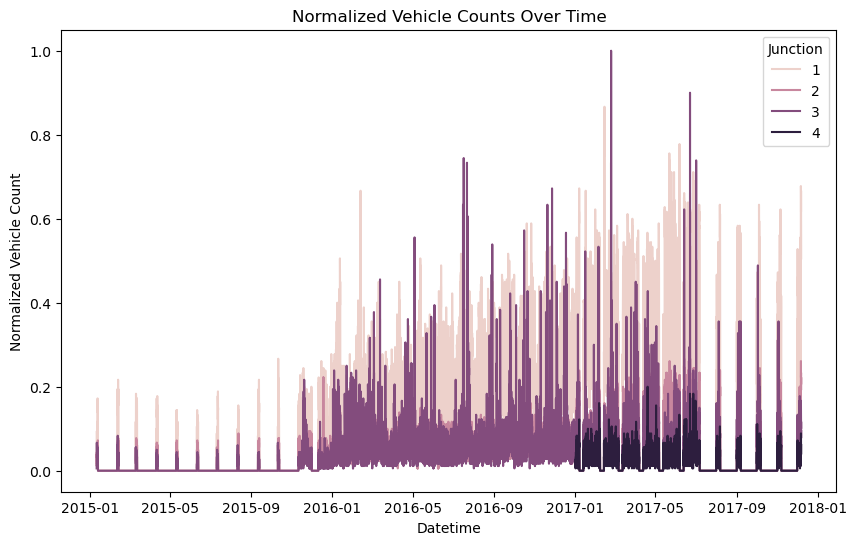

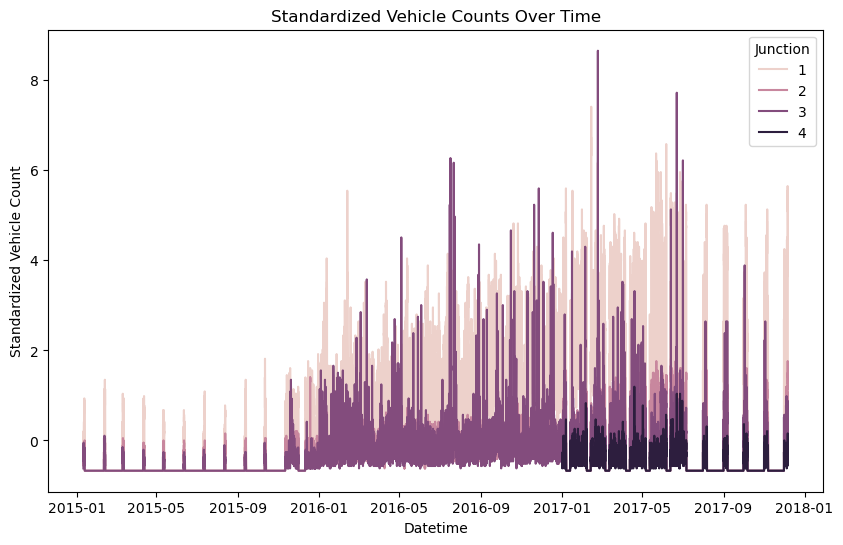

In [5]:
# Normalize the data using Min-Max scaling
scaler_minmax = MinMaxScaler()
hourly_traffic_data['vehicles_normalized'] = scaler_minmax.fit_transform(hourly_traffic_data[['Vehicles']])

# Standardize the data using Z-Score scaling
scaler_standard = StandardScaler()
hourly_traffic_data['vehicles_standardized'] = scaler_standard.fit_transform(hourly_traffic_data[['Vehicles']])

# Plot the normalized vehicle counts to visualize
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_traffic_data, x='DateTime', y='vehicles_normalized', hue='Junction')
plt.title('Normalized Vehicle Counts Over Time')
plt.xlabel('Datetime')
plt.ylabel('Normalized Vehicle Count')
plt.show()

# Plot the standardized vehicle counts to visualize
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_traffic_data, x='DateTime', y='vehicles_standardized', hue='Junction')
plt.title('Standardized Vehicle Counts Over Time')
plt.xlabel('Datetime')
plt.ylabel('Standardized Vehicle Count')
plt.show()



Feature Importances:
        feature  importance
4        lag_1    0.959159
0         hour    0.015374
6        lag_3    0.008121
5        lag_2    0.007981
2        month    0.005174
1  day_of_week    0.003589
3   is_weekend    0.000601


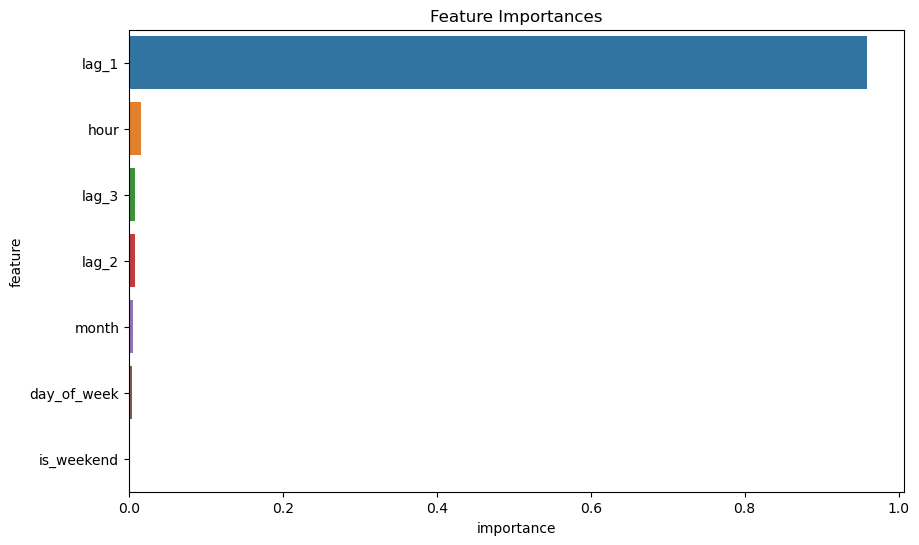

In [6]:
from sklearn.ensemble import RandomForestRegressor
# Evaluate Feature Importance
# Using a RandomForestRegressor to assess feature importance

# Define features and target variable
features = ['hour', 'day_of_week', 'month', 'is_weekend', 'lag_1', 'lag_2', 'lag_3']
X = hourly_traffic_data[features]
y = hourly_traffic_data['Vehicles']

# Fit the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display feature importances
print("\nFeature Importances:\n", feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()


In [7]:
import pandas as pd
import numpy as np

# Load traffic data
traffic_df = pd.read_csv('Dataset_Uber.csv')

# Convert datetime columns to datetime type
traffic_df['DateTime'] = pd.to_datetime(traffic_df['DateTime'])

# Load weather data
weather_df = pd.read_csv('weather_data.csv')

# Ensure weather data datetime is in datetime format
weather_df['DateTime'] = pd.to_datetime(weather_df['DateTime'])

# Standardize the weather data (optional but recommended for comparison)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
weather_df[['temperature', 'precipitation', 'humidity', 'windspeed']] = scaler.fit_transform(
    weather_df[['temperature', 'precipitation', 'humidity', 'windspeed']]
)

# Merge the datasets on datetime
merged_df = pd.merge(traffic_df, weather_df, on='DateTime', how='left')

# Handle missing values (impute with mean values or drop)
merged_df.fillna(merged_df.mean(), inplace=True)

# Remove duplicates
merged_df.drop_duplicates(inplace=True)

# Display the first few rows of the unified dataset
print(merged_df.head())
merged_df.to_csv("merged1_data.csv")


C:\Users\Madhu\AppData\Local\Temp\ipykernel_14992\3638867141.py:28: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  merged_df.fillna(merged_df.mean(), inplace=True)


             DateTime  Junction  Vehicles           ID  humidity  \
0 2015-01-11 00:00:00         1        15  20151101001 -1.092041   
1 2015-01-11 01:00:00         1        13  20151101011 -1.052540   
2 2015-01-11 02:00:00         1        10  20151101021 -0.973538   
3 2015-01-11 03:00:00         1         7  20151101031 -0.894537   
4 2015-01-11 04:00:00         1         9  20151101041 -0.894537   

   precipitation  temperature  visibility  windspeed  
0      -0.288702    -1.996889          10  -0.292704  
1      -0.288702    -1.996889          10  -0.292704  
2      -0.288702    -2.211499          10  -0.292704  
3      -0.288702    -2.211499          10  -0.502129  
4      -0.288702    -1.996889          10  -0.292704  


In [8]:
# Assuming 'merged_df' is your cleaned and merged dataset from previous steps

# Calculate average vehicle count per hour
hourly_vehicle_count = merged_df.groupby(merged_df['DateTime'].dt.hour)['Vehicles'].mean()


# Display congestion metrics
print("Hourly Vehicle Count:")
print(hourly_vehicle_count)


Hourly Vehicle Count:
DateTime
0     23.540648
1     19.654863
2     17.102743
3     14.847382
4     12.973067
5     12.173566
6     12.980050
7     14.703242
8     16.402993
9     19.379551
10    24.229925
11    27.495262
12    28.403990
13    25.588529
14    27.702743
15    27.650374
16    26.674314
17    26.648379
18    28.095262
19    29.854863
20    29.824938
21    28.202993
22    27.226933
23    25.635411
Name: Vehicles, dtype: float64


In [9]:
# Example of identifying peak hours using moving average
hourly_vehicle_count['rolling_mean'] = hourly_vehicle_count.rolling(window=3, min_periods=1).mean()

# Identify peak hours based on rolling mean or other statistical criteria
peak_hours = hourly_vehicle_count[hourly_vehicle_count['Vehicles'] > hourly_vehicle_count['rolling_mean']]

# Display identified peak hours
print("Peak Hours:")
print(peak_hours)


KeyError: 'Vehicles'

In [10]:
# Group by day of the week
daily_peak_hours = merged_df.groupby(merged_df['DateTime'].dt.dayofweek)['Vehicles'].mean()

# Explore monthly variations
monthly_peak_hours = merged_df.groupby(merged_df['DateTime'].dt.month)['Vehicles'].mean()

# Display temporal patterns
print("Daily Peak Hours:")
print(daily_peak_hours)
print("\nMonthly Peak Hours:")
print(monthly_peak_hours)


Daily Peak Hours:
DateTime
0    23.904496
1    24.853944
2    23.999129
3    24.315813
4    23.270325
5    20.061043
6    19.211351
Name: Vehicles, dtype: float64

Monthly Peak Hours:
DateTime
1     20.824121
2     23.312155
3     22.886307
4     23.475260
5     23.594640
6     25.372830
7     22.744241
8     22.099932
9     24.897569
10    24.827236
11    20.642720
12    19.752546
Name: Vehicles, dtype: float64


In [11]:
# Example of correlating peak hours with weather conditions
correlation_matrix = merged_df[['Vehicles', 'temperature', 'precipitation']].corr()

# Display correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
               Vehicles  temperature  precipitation
Vehicles       1.000000     0.120745       0.002657
temperature    0.120745     1.000000      -0.070685
precipitation  0.002657    -0.070685       1.000000


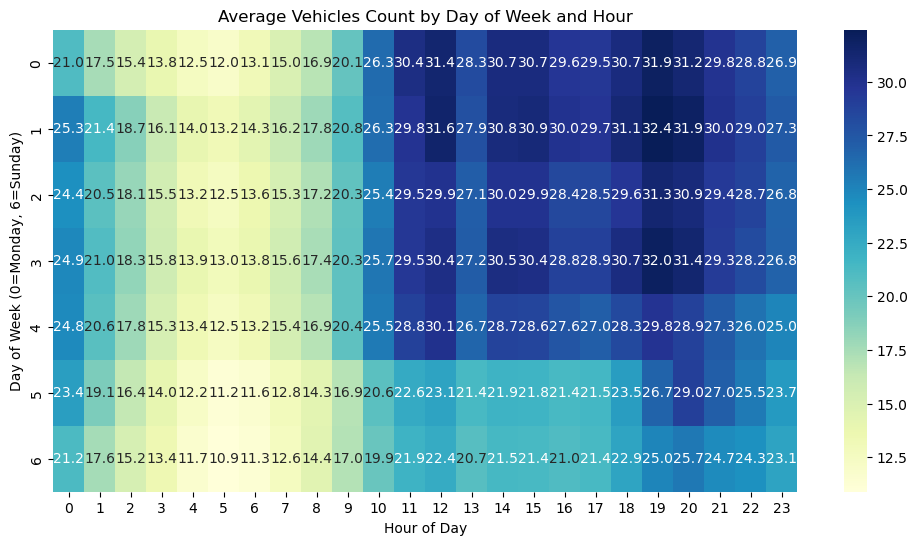

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by day of the week and hour to get average vehicle counts
hourly_peak_hours = merged_df.groupby([merged_df['DateTime'].dt.dayofweek, merged_df['DateTime'].dt.hour])['Vehicles'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(hourly_peak_hours, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Average Vehicles Count by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Monday, 6=Sunday)')
plt.show()

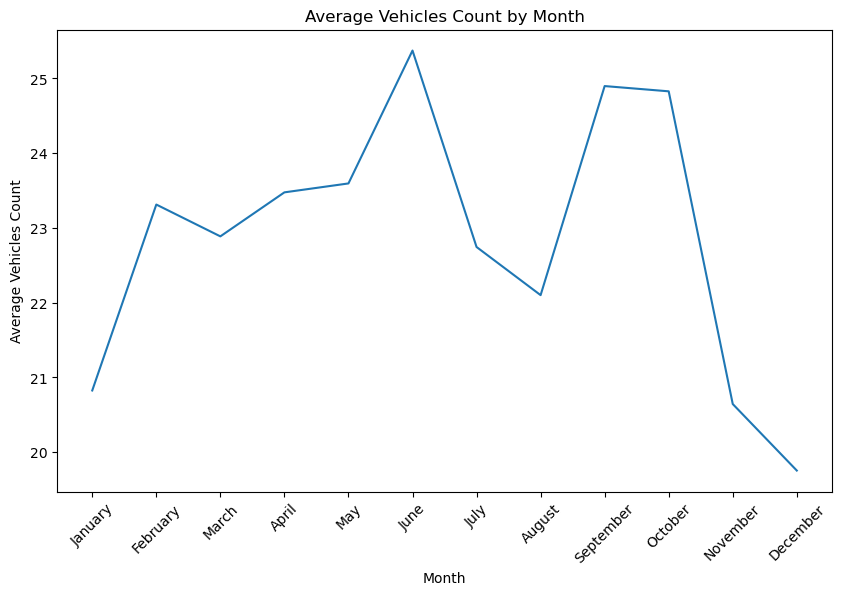

In [17]:
import calendar
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_peak_hours.index, y=monthly_peak_hours.values)
plt.title('Average Vehicles Count by Month')
plt.xlabel('Month')
plt.ylabel('Average Vehicles Count')
plt.xticks(monthly_peak_hours.index, calendar.month_name[1:13], rotation=45)
plt.show()


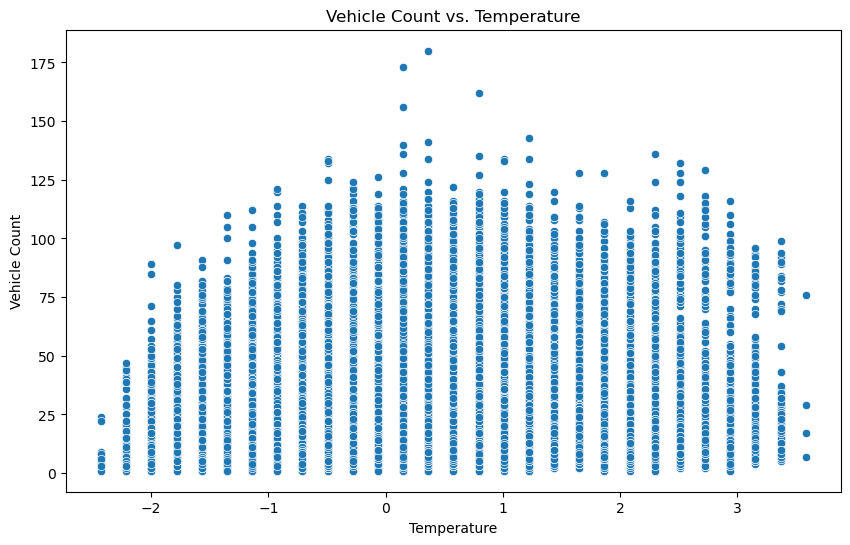

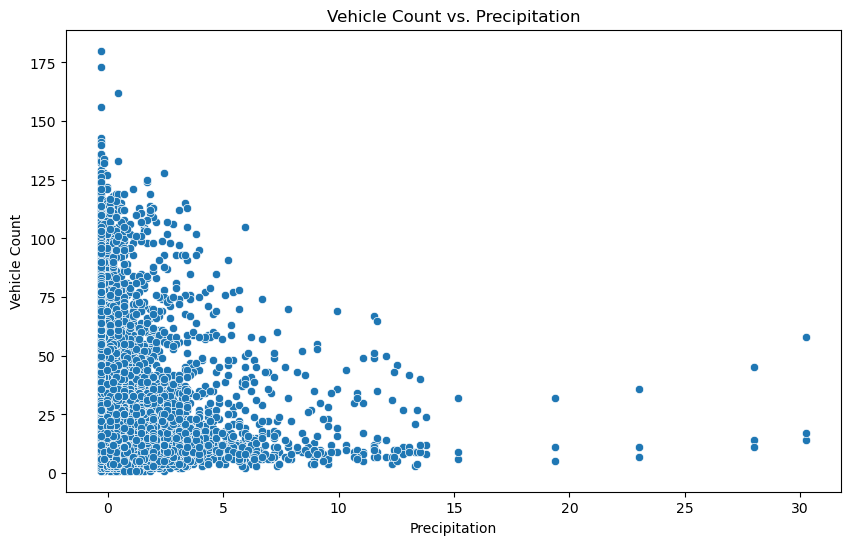

In [19]:
# Scatter plot for temperature vs. vehicle count
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df['temperature'], y=merged_df['Vehicles'])
plt.title('Vehicle Count vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('Vehicle Count')
plt.show()

# Scatter plot for precipitation vs. vehicle count
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df['precipitation'], y=merged_df['Vehicles'])
plt.title('Vehicle Count vs. Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Vehicle Count')
plt.show()


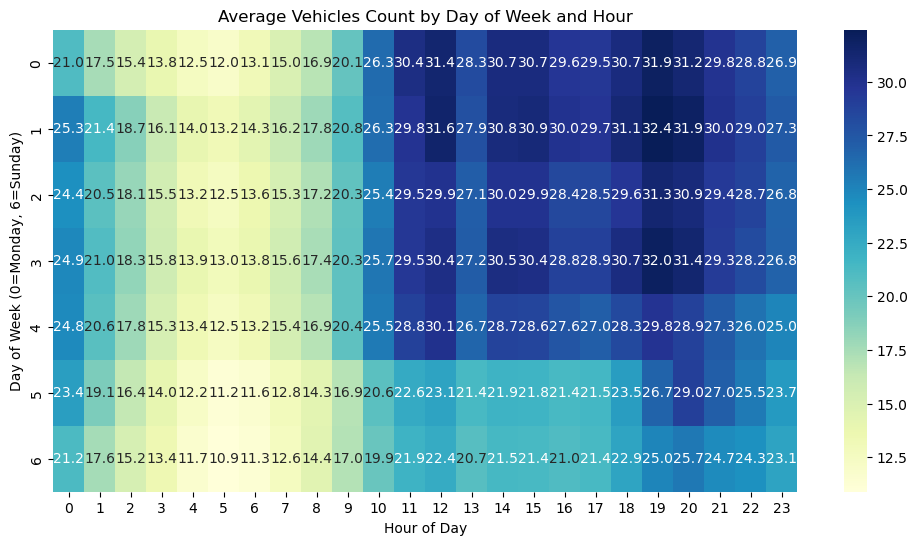

In [20]:
# Example for saving heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(Monthly_peak_hours, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Average Vehicles Count by Day of Week and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Monday, 6=Sunday)')
plt.savefig('heatmap_daily.png')
plt.show()


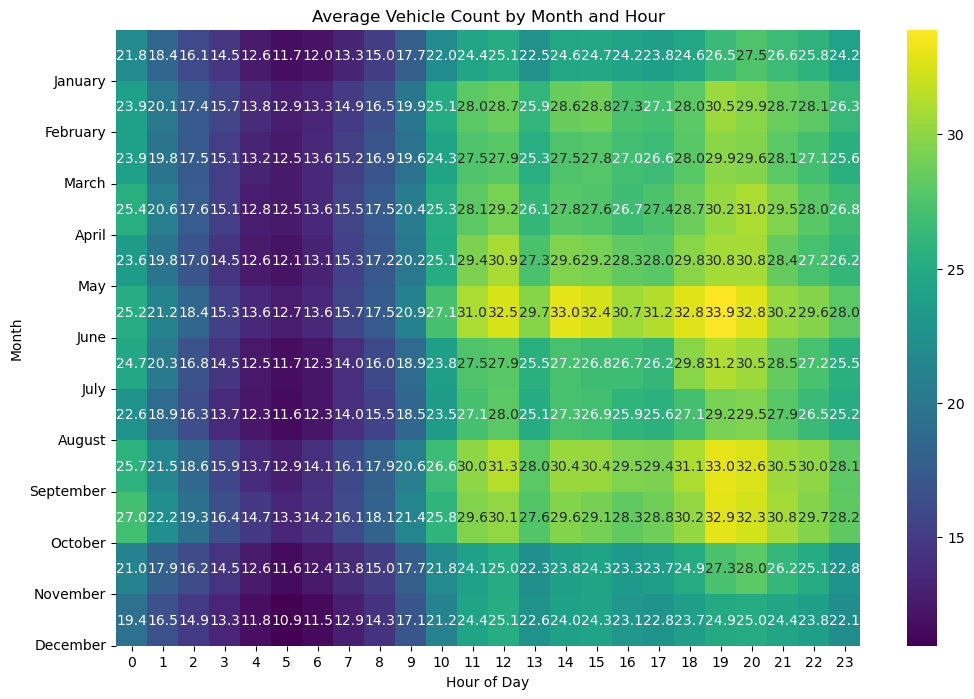

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

# Assuming merged_df is already defined and preprocessed

# Extract month and hour from DateTime
merged_df['month'] = merged_df['DateTime'].dt.month
merged_df['hour'] = merged_df['DateTime'].dt.hour

# Group by month and hour, then calculate the average vehicle count
monthly_hourly_peak = merged_df.groupby(['month', 'hour'])['Vehicles'].mean().unstack()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_hourly_peak, cmap='viridis', annot=True, fmt=".1f")
plt.title('Average Vehicle Count by Month and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Month')
plt.yticks(ticks=range(1, 13), labels=[calendar.month_name[i] for i in range(1, 13)], rotation=0)
plt.show()
